# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

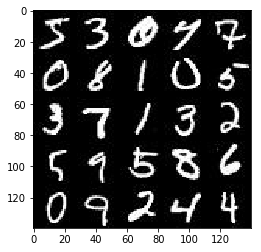

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

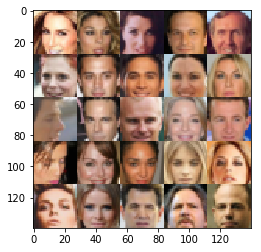

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    #Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = "input_z")
    learning_rate = tf.placeholder(tf.float32, (None))
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "D:\\Anaconda3\\envs\\simp\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "D:\\Anaconda3\\envs\\simp\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "D:\\Anaconda3\\envs\\simp\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "D:\\Anaconda3\\envs\\simp\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "D:\\Anaconda3\\envs\\simp\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "D:\\Anaconda3\\envs\\simp\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", line 177

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training = True)
        relu1 = tf.maximum(alpha * x1, x1)
                
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
        
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Implement Function
    reuse = not is_train
    alpha = 0.2 
    with tf.variable_scope("generator", reuse=reuse):
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)


        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)


        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)


        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')     
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss                                                                     


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith("generator")]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.4427
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.0682
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 3.0568
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 1.6922
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 1.1610
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 1.3458


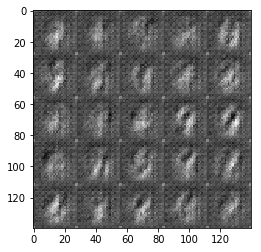

Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 2.0267
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.7241
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 1.5003
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 0.7967


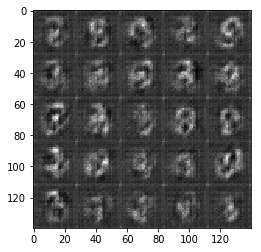

Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 1.3816
Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.4178
Epoch 1/2... Discriminator Loss: 0.8624... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 2.0124
Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 1.1704


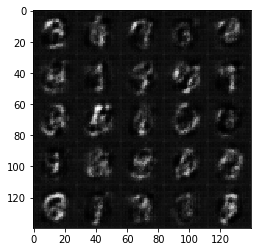

Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 0.6567
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 1.2448
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 2.3231
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 1.6286
Epoch 1/2... Discriminator Loss: 0.7828... Generator Loss: 1.6566
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 2.0053
Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 0.4626


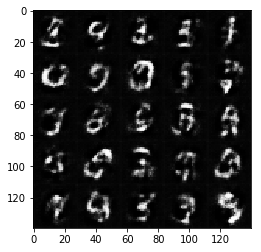

Epoch 1/2... Discriminator Loss: 0.6350... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 1.0826
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 2.2463
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.5190
Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 1.4897
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 2.1238


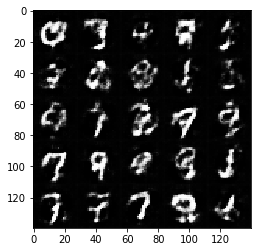

Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 2.2362
Epoch 1/2... Discriminator Loss: 0.7661... Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 2.0353
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 1.7853
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 1.8734
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.3155
Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 1.2655
Epoch 1/2... Discriminator Loss: 1.0069... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 0.9709


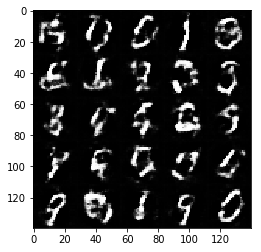

Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.2041
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 1.3408
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 1.1378... Generator Loss: 0.4931
Epoch 2/2... Discriminator Loss: 0.7842... Generator Loss: 1.4306
Epoch 2/2... Discriminator Loss: 0.7872... Generator Loss: 1.1407


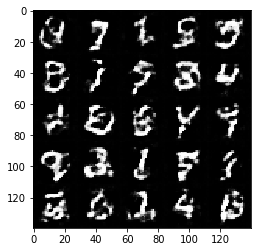

Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.5162
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.4026
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 1.6165
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.2476
Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 1.5062
Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.4564


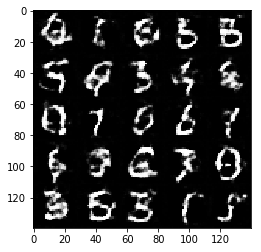

Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.0859
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.3914
Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.5782
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.6724
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 1.6027
Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 0.8461


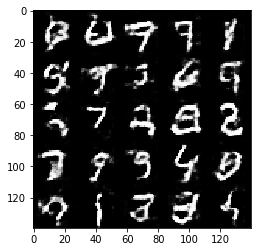

Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 1.2020
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 1.7773
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 1.8809
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.5501
Epoch 2/2... Discriminator Loss: 0.9424... Generator Loss: 1.5751
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 1.5466... Generator Loss: 0.3151


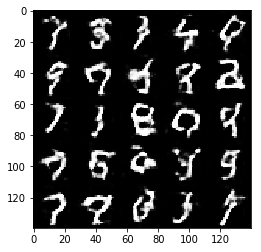

Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.1033
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 1.3400
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.6301
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 1.2168
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.7672


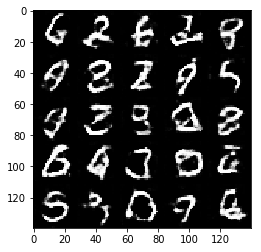

Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.5451
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 1.3589
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 1.6587
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 1.4794
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.1723
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 0.9535


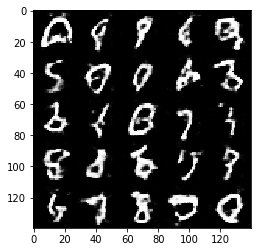

In [12]:
batch_size = 100
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2510... Generator Loss: 10.0628
Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 6.1255
Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 3.4569
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 0.1444... Generator Loss: 14.8725
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 3.3902
Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 4.0447
Epoch 1/1... Discriminator Loss: 2.0511... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 5.7621


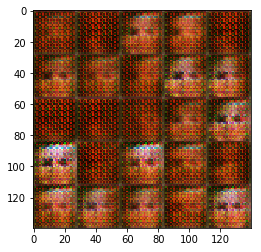

Epoch 1/1... Discriminator Loss: 4.1128... Generator Loss: 9.1459
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.6545
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.8379... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.8990
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.3293


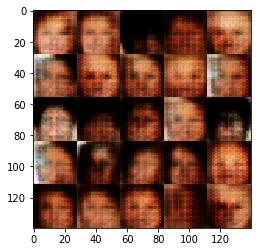

Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 2.1474
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.9567
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.3688


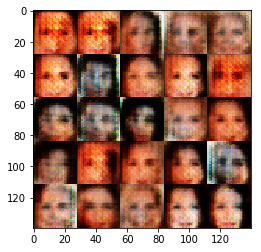

Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 2.1853
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 2.6362
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 4.0064
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 2.4748... Generator Loss: 4.3444


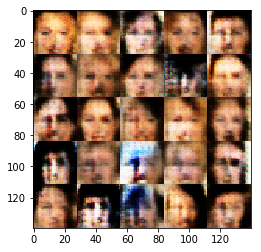

Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.0650
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.2887
Epoch 1/1... Discriminator Loss: 0.2385... Generator Loss: 2.3855
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.6227
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 2.5938
Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.2394
Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.3236


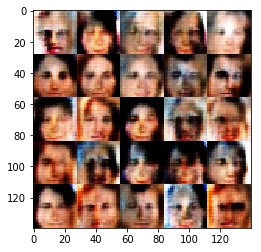

Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 2.3958
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.3642
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 1.6575
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.3535
Epoch 1/1... Discriminator Loss: 1.9240... Generator Loss: 0.2082


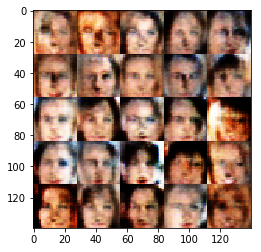

Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 2.8890
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 2.2859
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 3.8096
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 1.7514
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 1.7553... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 1.7615
Epoch 1/1... Discriminator Loss: 0.2693... Generator Loss: 5.7069


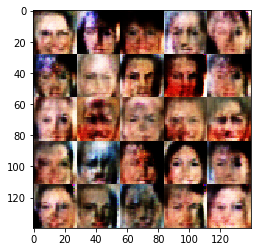

Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.0949
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.3604
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 1.8996
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.5418
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.6180
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.3945
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 2.3050
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 0.9901


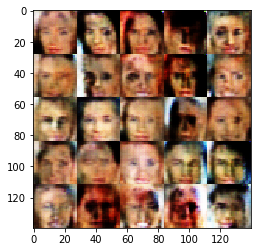

Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 3.9015
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 4.0456
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 4.2988
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 1.6007
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 2.4692
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 0.2848... Generator Loss: 2.9767
Epoch 1/1... Discriminator Loss: 0.1268... Generator Loss: 4.9201


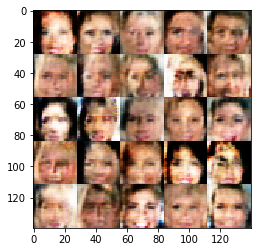

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 4.9413
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.7544... Generator Loss: 0.2883
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 0.0994... Generator Loss: 4.2537
Epoch 1/1... Discriminator Loss: 0.3217... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 1.4599
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 0.9702


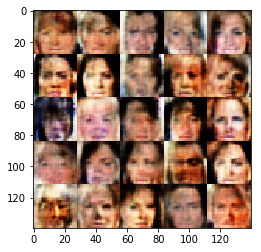

Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 2.4484
Epoch 1/1... Discriminator Loss: 0.1628... Generator Loss: 2.8631
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 2.1422
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 2.4036


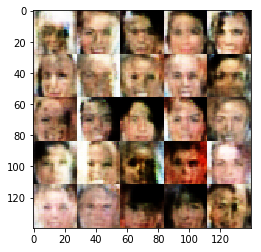

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.4093
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 0.2999
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 1.8636
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 3.5528
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.2135


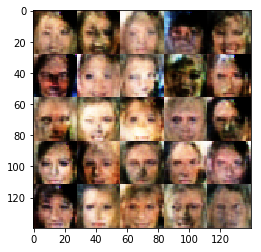

Epoch 1/1... Discriminator Loss: 0.2045... Generator Loss: 2.6057
Epoch 1/1... Discriminator Loss: 0.2528... Generator Loss: 1.8964
Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 4.8839
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: 0.1708... Generator Loss: 2.4999
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 2.4312... Generator Loss: 0.1725
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.2494


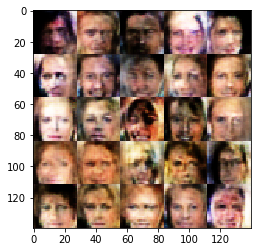

Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 2.8189
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 2.9027
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.9535
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.8771
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.0571


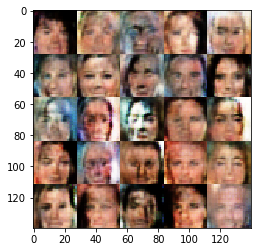

Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 1.9726
Epoch 1/1... Discriminator Loss: 0.3037... Generator Loss: 3.6523
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.1906
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 2.1649
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 3.1644
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 2.2444
Epoch 1/1... Discriminator Loss: 0.3041... Generator Loss: 3.4033
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 3.3452
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.7280
Epoch 1/1... Discriminator Loss: 0.2806... Generator Loss: 2.4205


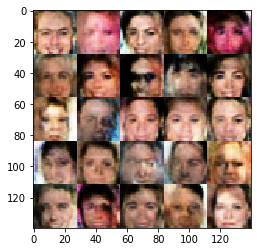

Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 0.2687... Generator Loss: 2.0059
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 0.2651... Generator Loss: 2.3754
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 4.2267
Epoch 1/1... Discriminator Loss: 1.7060... Generator Loss: 3.9638
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 2.6339... Generator Loss: 0.1179


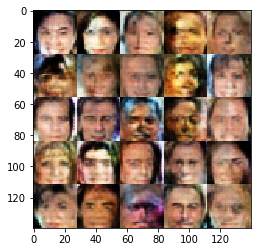

Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 3.0575
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 1.8056
Epoch 1/1... Discriminator Loss: 0.3104... Generator Loss: 2.4512
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.1716... Generator Loss: 2.5236


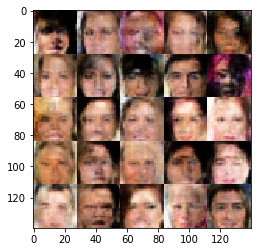

Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 1.7250
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 3.1261
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 0.1599... Generator Loss: 3.5216
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.1656... Generator Loss: 2.5015
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 2.1029


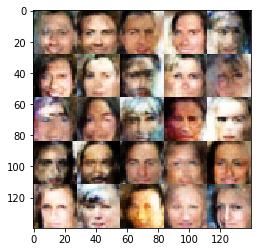

Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 2.1714
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 1.5047
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 3.9920
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 3.1915
Epoch 1/1... Discriminator Loss: 2.6864... Generator Loss: 0.1117
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 2.9618
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 1.9439


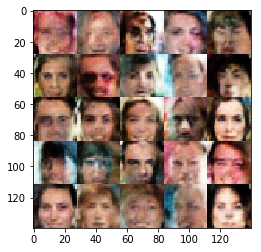

Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 2.7443
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 3.1228
Epoch 1/1... Discriminator Loss: 0.2276... Generator Loss: 3.4382
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 2.5330... Generator Loss: 0.1378
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 1.7614
Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.2639... Generator Loss: 2.2056
Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 3.1645
Epoch 1/1... Discriminator Loss: 0.2412... Generator Loss: 2.8068


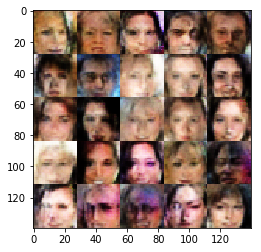

Epoch 1/1... Discriminator Loss: 0.2287... Generator Loss: 2.3375
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 3.2884


In [16]:
batch_size = 100
z_dim = 200
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.